In [ ]:
# =========================================
# 1. Imports
# =========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib   # For saving the trained model


In [ ]:
# =========================================
# 2. Load Raw Data
# =========================================
weather = pd.read_csv("weather_in_Antwerp.csv", sep=";", engine='python', on_bad_lines='skip')
solar = pd.read_csv("panel.csv")

print("Raw weather shape:", weather.shape)
print("Raw solar shape:", solar.shape)


Raw weather shape: (15851, 11)
Raw solar shape: (3304, 4)


In [ ]:
# =========================================
# 2.1 Understand the Data
# =========================================
print("Weather Data Overview:")
weather.info()
display(weather.head())
display(weather.describe())


Weather Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15851 entries, 0 to 15850
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  15851 non-null  int64  
 1   clock       15851 non-null  object 
 2   temp        15843 non-null  object 
 3   weather     15851 non-null  object 
 4   wind        15821 non-null  object 
 5   humidity    15841 non-null  object 
 6   barometer   15845 non-null  object 
 7   visibility  8266 non-null   object 
 8   year        15851 non-null  int64  
 9   month       15850 non-null  float64
 10  day         15850 non-null  float64
dtypes: float64(2), int64(2), object(7)
memory usage: 1.3+ MB


,Unnamed: 0,clock,temp,weather,wind,humidity,barometer,visibility,year,month,day
0,0,00:20,11 °C,Mostly cloudy.,17 km/h,94%,1011 mbar,5 km,2012,1.0,1.0
1,1,00:50,12 °C,Mostly cloudy.,17 km/h,88%,1011 mbar,NaN,2012,1.0,1.0
2,2,01:50,12 °C,Overcast.,19 km/h,88%,1011 mbar,9 km,2012,1.0,1.0
3,3,02:20,12 °C,Partly cloudy.,17 km/h,88%,1010 mbar,NaN,2012,1.0,1.0
4,4,02:50,12 °C,Sprinkles. Mostly cloudy.,15 km/h,88%,1010 mbar,NaN,2012,1.0,1.0


,Unnamed: 0,year,month,day
count,15851.000000,15851.0,15850.000000,15850.000000
mean,683.484260,2012.0,6.171798,15.148833
std,405.576018,0.0,3.273292,8.688233
min,0.000000,2012.0,1.000000,1.000000
25%,330.000000,2012.0,3.000000,8.000000
50%,674.000000,2012.0,6.000000,15.000000
75%,1035.000000,2012.0,9.000000,23.000000
max,1430.000000,2012.0,12.000000,30.000000


In [ ]:
print("Solar Data Overview:")
solar.info()
display(solar.head())
display(solar.describe())

Solar Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3304 entries, 0 to 3303
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   date                    3304 non-null   object 
 1   Cumulative_solar_power  3304 non-null   float64
 2   kWh electricity/day     3304 non-null   float64
 3   Gas/day                 3304 non-null   float64
dtypes: float64(3), object(1)
memory usage: 103.4+ KB


,date,Cumulative_solar_power,kWh electricity/day,Gas/day
0,26/10/2011,0.1,15.1,9.0
1,27/10/2011,10.2,7.4,9.2
2,28/10/2011,20.2,5.8,8.0
3,29/10/2011,29.6,4.9,6.6
4,30/10/2011,34.2,11.7,5.3


,Cumulative_solar_power,kWh electricity/day,Gas/day
count,3304.000000,3304.000000,3304.000000
mean,17616.116435,4.585048,8.343705
std,10577.158537,9.856726,6.334102
min,0.100000,-24.000000,0.000000
25%,8089.500000,-3.000000,2.000000
50%,17184.500000,6.000000,8.000000
75%,27116.500000,13.000000,13.000000
max,36469.000000,34.000000,29.000000


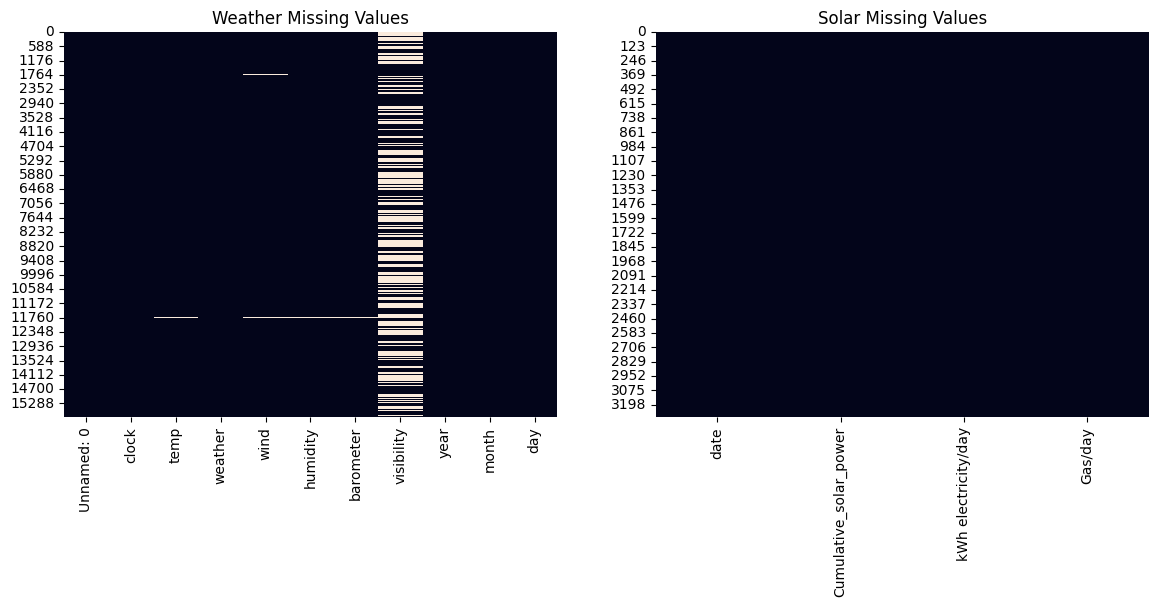

In [ ]:
# =========================================
# 2.2 Inspect Missing Values
# =========================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.heatmap(weather.isnull(), cbar=False, ax=axes[0])
axes[0].set_title("Weather Missing Values")

sns.heatmap(solar.isnull(), cbar=False, ax=axes[1])
axes[1].set_title("Solar Missing Values")
plt.show()

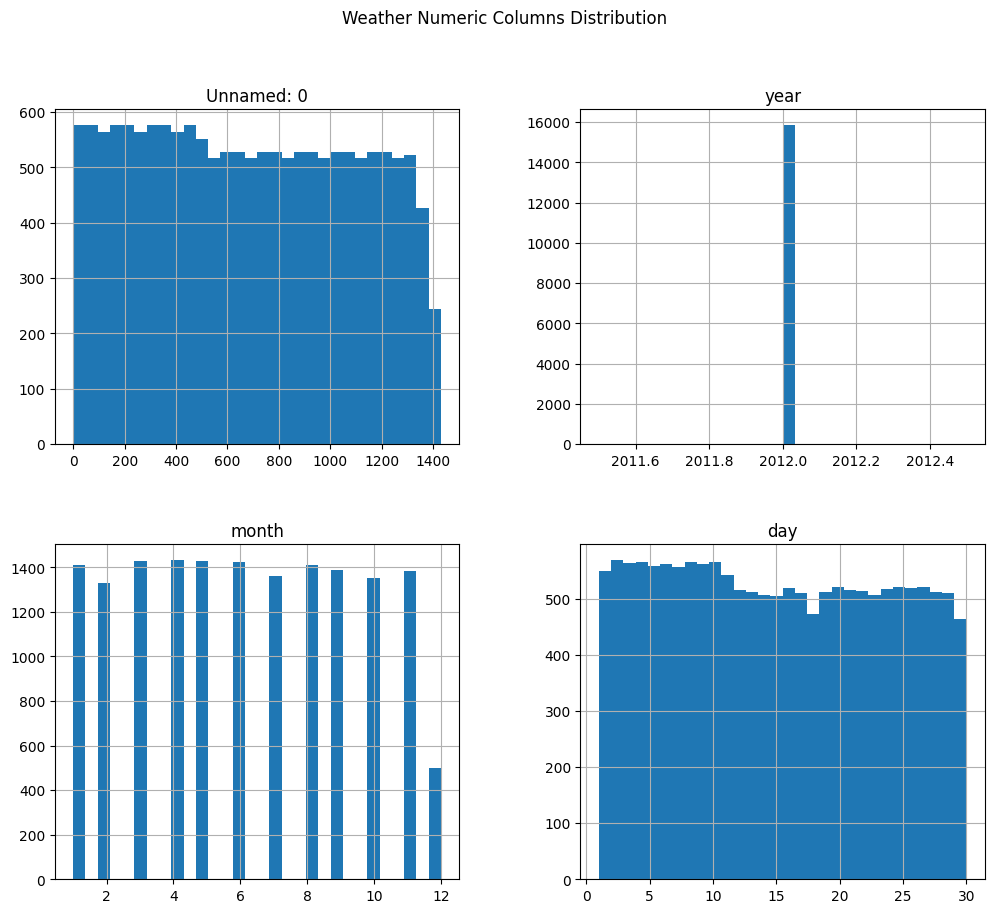

In [ ]:
# Distributions
weather.hist(figsize=(12,10), bins=30)
plt.suptitle("Weather Numeric Columns Distribution")
plt.show()

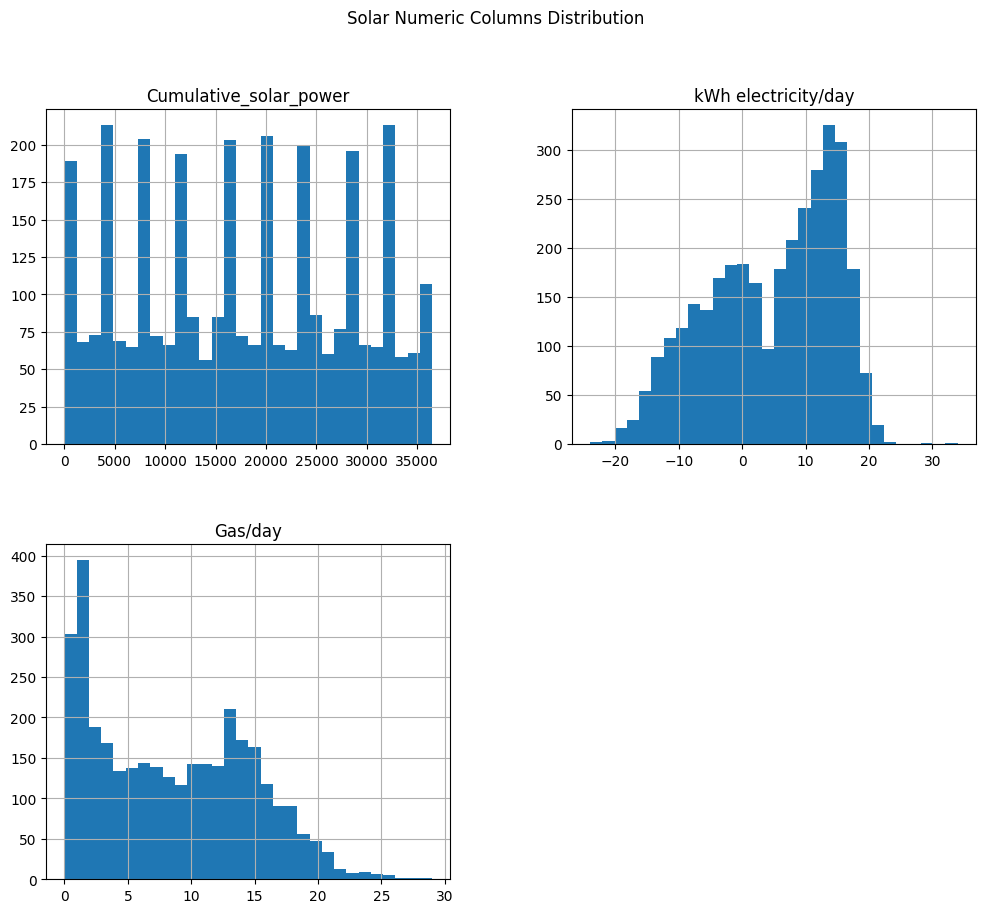

In [ ]:
solar.hist(figsize=(12,10), bins=30)
plt.suptitle("Solar Numeric Columns Distribution")
plt.show()


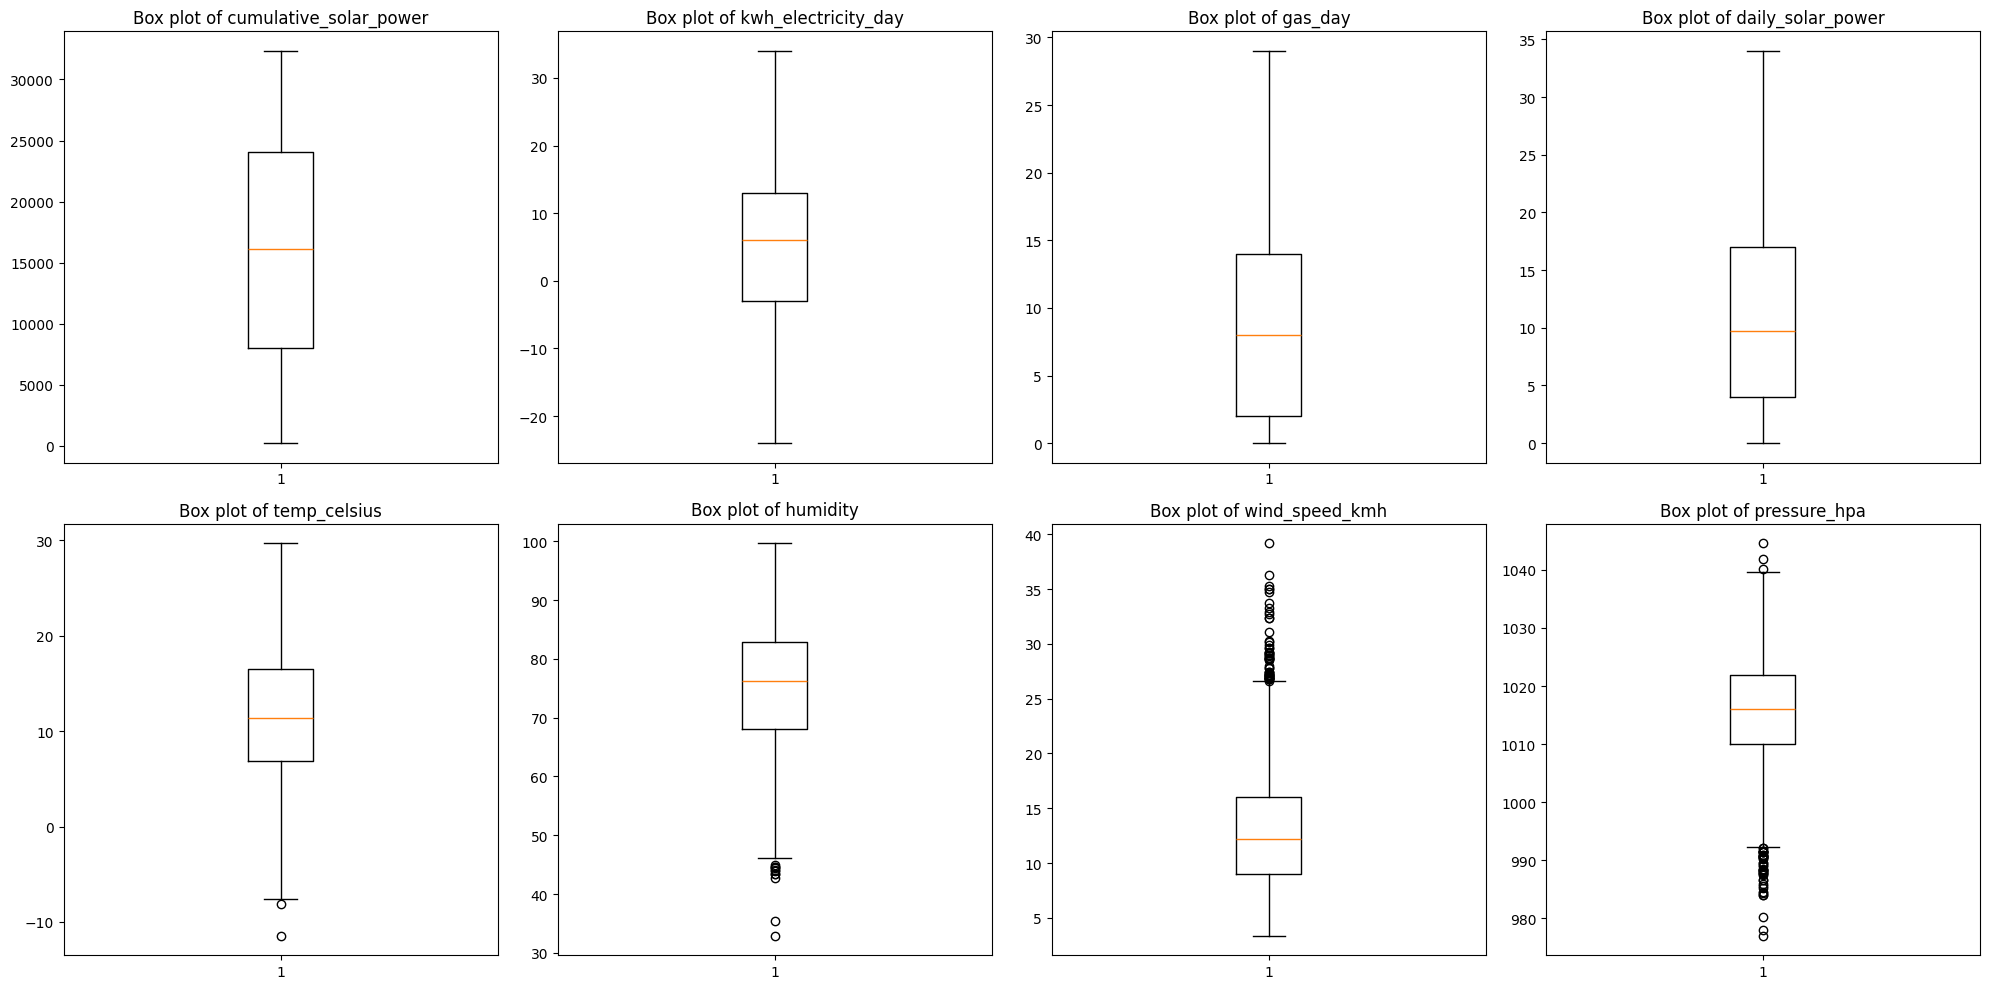

In [ ]:
# =========================================
# Box Plots of Numeric Columns
# =========================================
# It works even if the kernel was restarted and final_data doesn't exist yet.

import pandas as pd, numpy as np, matplotlib.pyplot as plt

def _clean_numeric(df, col, unit=""):
    return pd.to_numeric(
        df[col].astype(str).str.replace(unit, "", regex=False).str.replace(",", ".", regex=False).str.strip(),
        errors="coerce"
    )

# 1) Ensure final_data exists (rebuild if missing)
if 'final_data' not in globals():
    # -- Load CSVs (adjust paths if needed) --
    panel = pd.read_csv("panel.csv")
    weather = pd.read_csv("weather_in_Antwerp.csv", sep=";", engine="python", on_bad_lines="skip")

    # -- Dates --
    panel["date"]   = pd.to_datetime(panel["date"], dayfirst=True, errors="coerce")
    if {"year","month","day"}.issubset(weather.columns):
        weather["date"] = pd.to_datetime(weather[["year","month","day"]], errors="coerce")
    elif "date" in weather.columns:
        weather["date"] = pd.to_datetime(weather["date"], errors="coerce")
    else:
        raise ValueError("Could not find date in weather file (need year,month,day or a 'date' column).")

    # -- Weather numerics --
    for src, col, unit in [("temp","temp_celsius","°C"),
                           ("humidity","humidity","%"),
                           ("wind","wind_speed_kmh"," km/h"),
                           ("barometer","pressure_hpa"," mbar")]:
        if src in weather.columns:
            weather[col] = _clean_numeric(weather, src, unit)

    weather_daily = weather.groupby("date").agg(
        temp_celsius=("temp_celsius","mean"),
        humidity=("humidity","mean"),
        wind_speed_kmh=("wind_speed_kmh","mean"),
        pressure_hpa=("pressure_hpa","mean"),
        weather=("weather", lambda x: x.mode()[0] if not x.mode().empty else "unknown")
    ).reset_index()

    # -- Panel cleaning --
    panel = panel.rename(columns={
        "Cumulative_solar_power":"cumulative_solar_power",
        "kWh electricity/day":"kwh_electricity_day",
        "Gas/day":"gas_day"
    })
    if "cumulative_solar_power" in panel.columns:
        panel["cumulative_solar_power"] = panel["cumulative_solar_power"].ffill()
        panel["daily_solar_power"] = panel["cumulative_solar_power"].diff().fillna(0)
    elif "daily_solar_power" not in panel.columns:
        raise ValueError("Panel file must have cumulative_solar_power or daily_solar_power.")

    for c in ["kwh_electricity_day","gas_day"]:
        if c in panel.columns:
            panel[c] = panel[c].fillna(panel[c].median())

    final_data = pd.merge(panel, weather_daily, on="date", how="inner").sort_values("date").reset_index(drop=True)

# 2) Ensure encoded frame exists
if 'weather' in final_data.columns:
    final_data_encoded = pd.get_dummies(final_data, columns=['weather'], drop_first=True)
else:
    final_data_encoded = final_data.copy()

# 3) Select numeric columns, drop no-variance cols
dfn = final_data_encoded.select_dtypes(include=np.number)
dfn = dfn.loc[:, dfn.nunique(dropna=True) > 1]

# 4) Plot 4-per-row boxplots
numeric_cols_encoded = dfn.columns
n_cols = len(numeric_cols_encoded)
if n_cols == 0:
    raise ValueError("No numeric columns to plot after encoding/cleaning.")

n_rows = (n_cols + 3) // 4
fig, axes = plt.subplots(n_rows, 4, figsize=(20, 5 * max(n_rows,1)))
axes = np.atleast_1d(axes).flatten()

for i, col in enumerate(numeric_cols_encoded):
    axes[i].boxplot(dfn[col].dropna())
    axes[i].set_title(f"Box plot of {col}")
    axes[i].set_ylabel('')

# Hide unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
# ========================================================================

In [ ]:
# =========================================
# 2.3 Handle Missing Values
# =========================================
# Drop columns with more than 50% missing data
weather = weather.dropna(axis=1, thresh=len(weather)*0.5)
solar = solar.dropna(axis=1, thresh=len(solar)*0.5)

# Fill numeric columns with median
for col in weather.select_dtypes(include='number'):
    weather[col].fillna(weather[col].median(), inplace=True)
for col in solar.select_dtypes(include='number'):
    solar[col].fillna(solar[col].median(), inplace=True)

# Flag missing rows
weather['missing_flag'] = weather.isnull().any(axis=1).astype(int)
solar['missing_flag'] = solar.isnull().any(axis=1).astype(int)


/tmp/ipython-input-93579835.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  weather[col].fillna(weather[col].median(), inplace=True)
/tmp/ipython-input-93579835.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', 

In [ ]:
# =========================================
# 2.4 Remove Duplicates
# =========================================
before_weather = weather.shape[0]
before_solar = solar.shape[0]

weather.drop_duplicates(inplace=True)
solar.drop_duplicates(inplace=True)

print(f"Removed {before_weather - weather.shape[0]} duplicates from Weather")
print(f"Removed {before_solar - solar.shape[0]} duplicates from Solar")


Removed 0 duplicates from Weather
Removed 0 duplicates from Solar


In [ ]:
# =========================================
# 3. Clean Solar Data
# =========================================
solar['date'] = pd.to_datetime(solar['date'], dayfirst=True, errors="coerce")
solar.rename(columns={
    "Cumulative_solar_power": "cumulative_solar_power",
    "kWh electricity/day": "kwh_electricity_day",
    "Gas/day": "gas_day"
}, inplace=True)

# Handle missing and derive daily power
solar['cumulative_solar_power'] = solar['cumulative_solar_power'].ffill()
solar['kwh_electricity_day'] = solar['kwh_electricity_day'].fillna(solar['kwh_electricity_day'].median())
solar['gas_day'] = solar['gas_day'].fillna(solar['gas_day'].median())
solar['daily_solar_power'] = solar['cumulative_solar_power'].diff().fillna(0)

print("✅ Solar cleaned:", solar.shape)


✅ Solar cleaned: (3304, 6)


In [ ]:
# =========================================
# 4. Clean Weather Data
# =========================================
weather['date'] = pd.to_datetime(weather[['year', 'month', 'day']], errors='coerce')

def clean_numeric(df, col, unit=""):
    """Convert strings with units into numeric values"""
    return pd.to_numeric(
        df[col]
        .astype(str)
        .str.replace(unit, "", regex=False)
        .str.replace(",", ".", regex=False)
        .str.strip(),
        errors="coerce"
    )

weather['temp_celsius'] = clean_numeric(weather, "temp", "°C")
weather['humidity'] = clean_numeric(weather, "humidity", "%")
weather['wind_speed_kmh'] = clean_numeric(weather, "wind", " km/h")
weather['pressure_hpa'] = clean_numeric(weather, "barometer", " mbar")

# Impute missing temp_celsius before daily aggregation
weather['temp_celsius'] = weather['temp_celsius'].fillna(weather['temp_celsius'].median())

In [ ]:
# Aggregate daily values
weather_daily = weather.groupby("date").agg({
    "temp_celsius": "mean",
    "humidity": "mean",
    "wind_speed_kmh": "mean",
    "pressure_hpa": "mean",
    "weather": lambda x: x.mode()[0] if not x.mode().empty else "unknown"
}).reset_index()

print("✅ Weather cleaned:", weather_daily.shape)


✅ Weather cleaned: (2865, 6)


In [ ]:
# =========================================
# 5. Merge Solar + Weather
# =========================================
final_data = pd.merge(solar, weather_daily, on="date", how="inner")

# Drop unwanted columns
if "visibility_km" in final_data.columns:
    final_data.drop(columns=["visibility_km"], inplace=True)

# Save clean dataset
final_data.to_csv("solar_weather_clean.csv", index=False)
print("✅ Final dataset saved as solar_weather_clean.csv")
print("Final dataset shape:", final_data.shape)
print("\n=== Cleaned Dataset Preview ===")
display(final_data.head(20))



✅ Final dataset saved as solar_weather_clean.csv
Final dataset shape: (2865, 11)

=== Cleaned Dataset Preview ===


,date,cumulative_solar_power,kwh_electricity_day,gas_day,missing_flag,daily_solar_power,temp_celsius,humidity,wind_speed_kmh,pressure_hpa,weather
0,2012-01-01,226.7,16.0,13.6,0,0.5,12.333333,89.333333,21.333333,1007.866667,Mostly cloudy.
1,2012-01-02,227.5,18.8,10.6,0,0.8,7.787234,81.425532,17.212766,1009.170213,Passing clouds.
2,2012-01-03,230.4,15.5,11.7,0,2.9,8.208333,78.229167,32.354167,1007.916667,Clear.
3,2012-01-04,231.2,19.3,19.3,0,0.8,7.354167,71.041667,26.375000,1012.687500,Passing clouds.
4,2012-01-05,233.9,6.9,10.6,0,2.7,8.292683,77.804878,39.170732,998.219512,Partly cloudy.
5,2012-01-06,235.5,16.1,14.9,0,1.6,6.291667,76.833333,26.000000,1019.333333,Broken clouds.
6,2012-01-07,236.5,14.9,15.4,0,1.0,7.958333,77.479167,25.312500,1018.312500,Passing clouds.
7,2012-01-08,240.6,15.1,14.6,0,4.1,7.456522,77.956522,17.456522,1023.282609,Passing clouds.
8,2012-01-09,245.8,13.2,13.5,0,5.2,8.434783,85.543478,14.065217,1027.913043,Partly sunny.
9,2012-01-10,246.8,10.9,11.8,0,1.0,9.148936,84.446809,10.106383,1032.829787,Passing clouds.


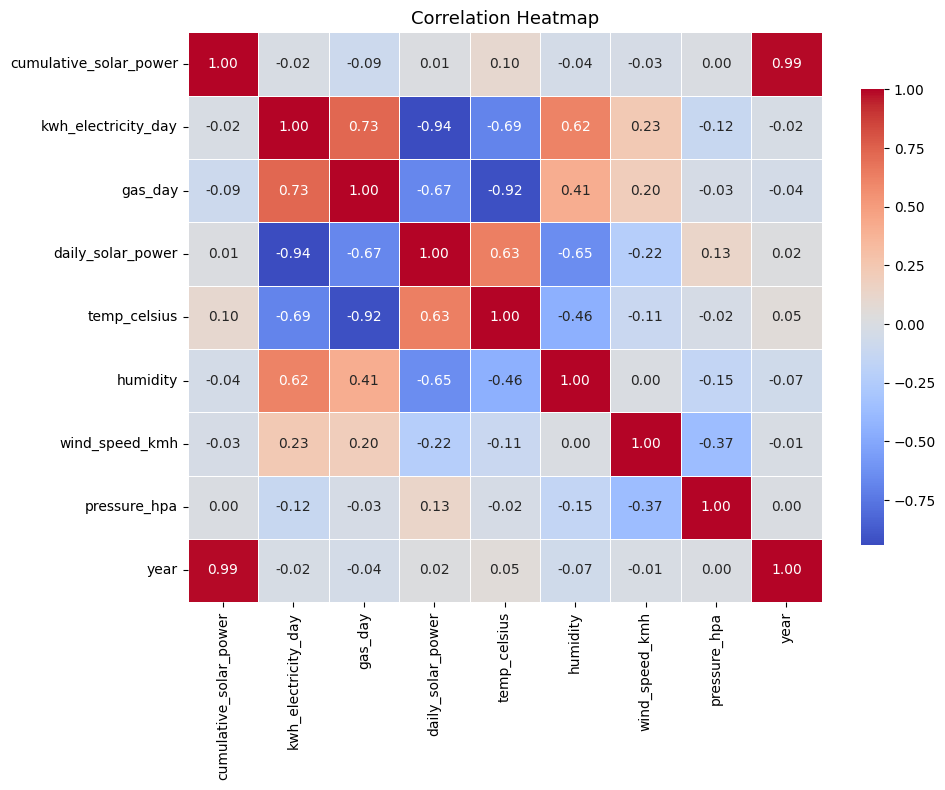

In [ ]:
# =========================================
# 6. Exploratory Data Analysis (EDA)
# =========================================

# --- Ensure date and year are correct ---
final_data['date'] = pd.to_datetime(final_data['date'])
final_data['year'] = final_data['date'].dt.year

# --- Correlation Heatmap (clean & complete version) ---
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Keep only numeric columns
num_cols = final_data.select_dtypes(include=[np.number])

# Drop columns with no variance (e.g. flags)
num_cols = num_cols.loc[:, num_cols.std() > 0]

# Fill missing values with medians
num_cols = num_cols.fillna(num_cols.median())

# Compute correlations
corr = num_cols.corr()

# Plot clean, complete heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)
plt.title("Correlation Heatmap", fontsize=13)
plt.tight_layout()
plt.show()

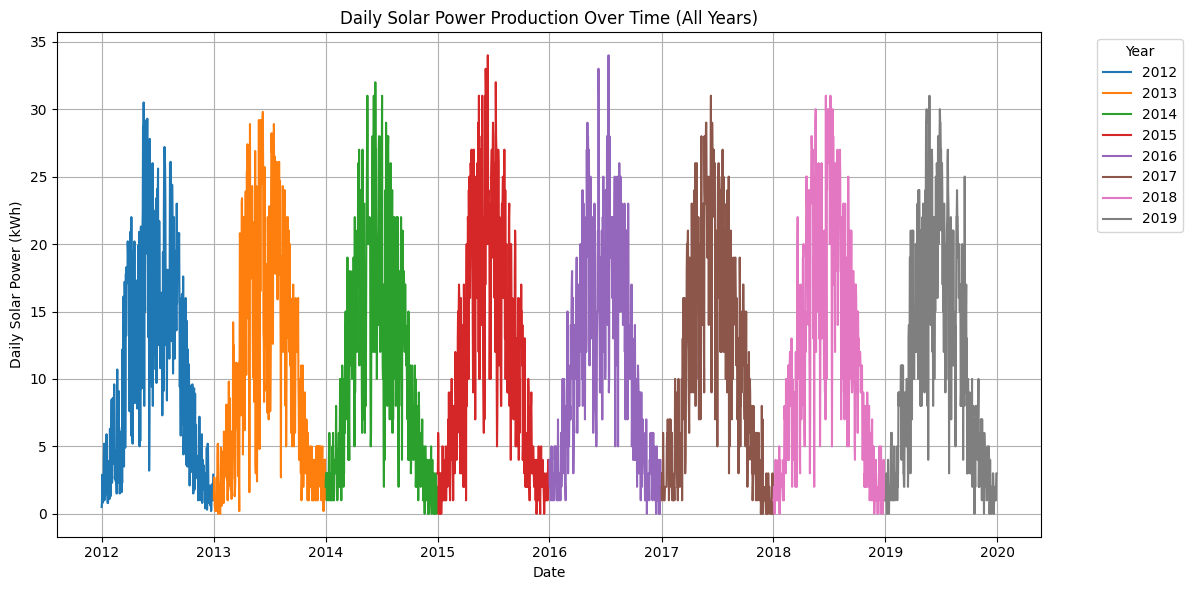

In [ ]:

# Combined graph
plt.figure(figsize=(12, 6))
for year, data in final_data.groupby('year'):
    plt.plot(data['date'], data['daily_solar_power'], label=str(year))
plt.title('Daily Solar Power Production Over Time (All Years)')
plt.xlabel('Date')
plt.ylabel('Daily Solar Power (kWh)')
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()



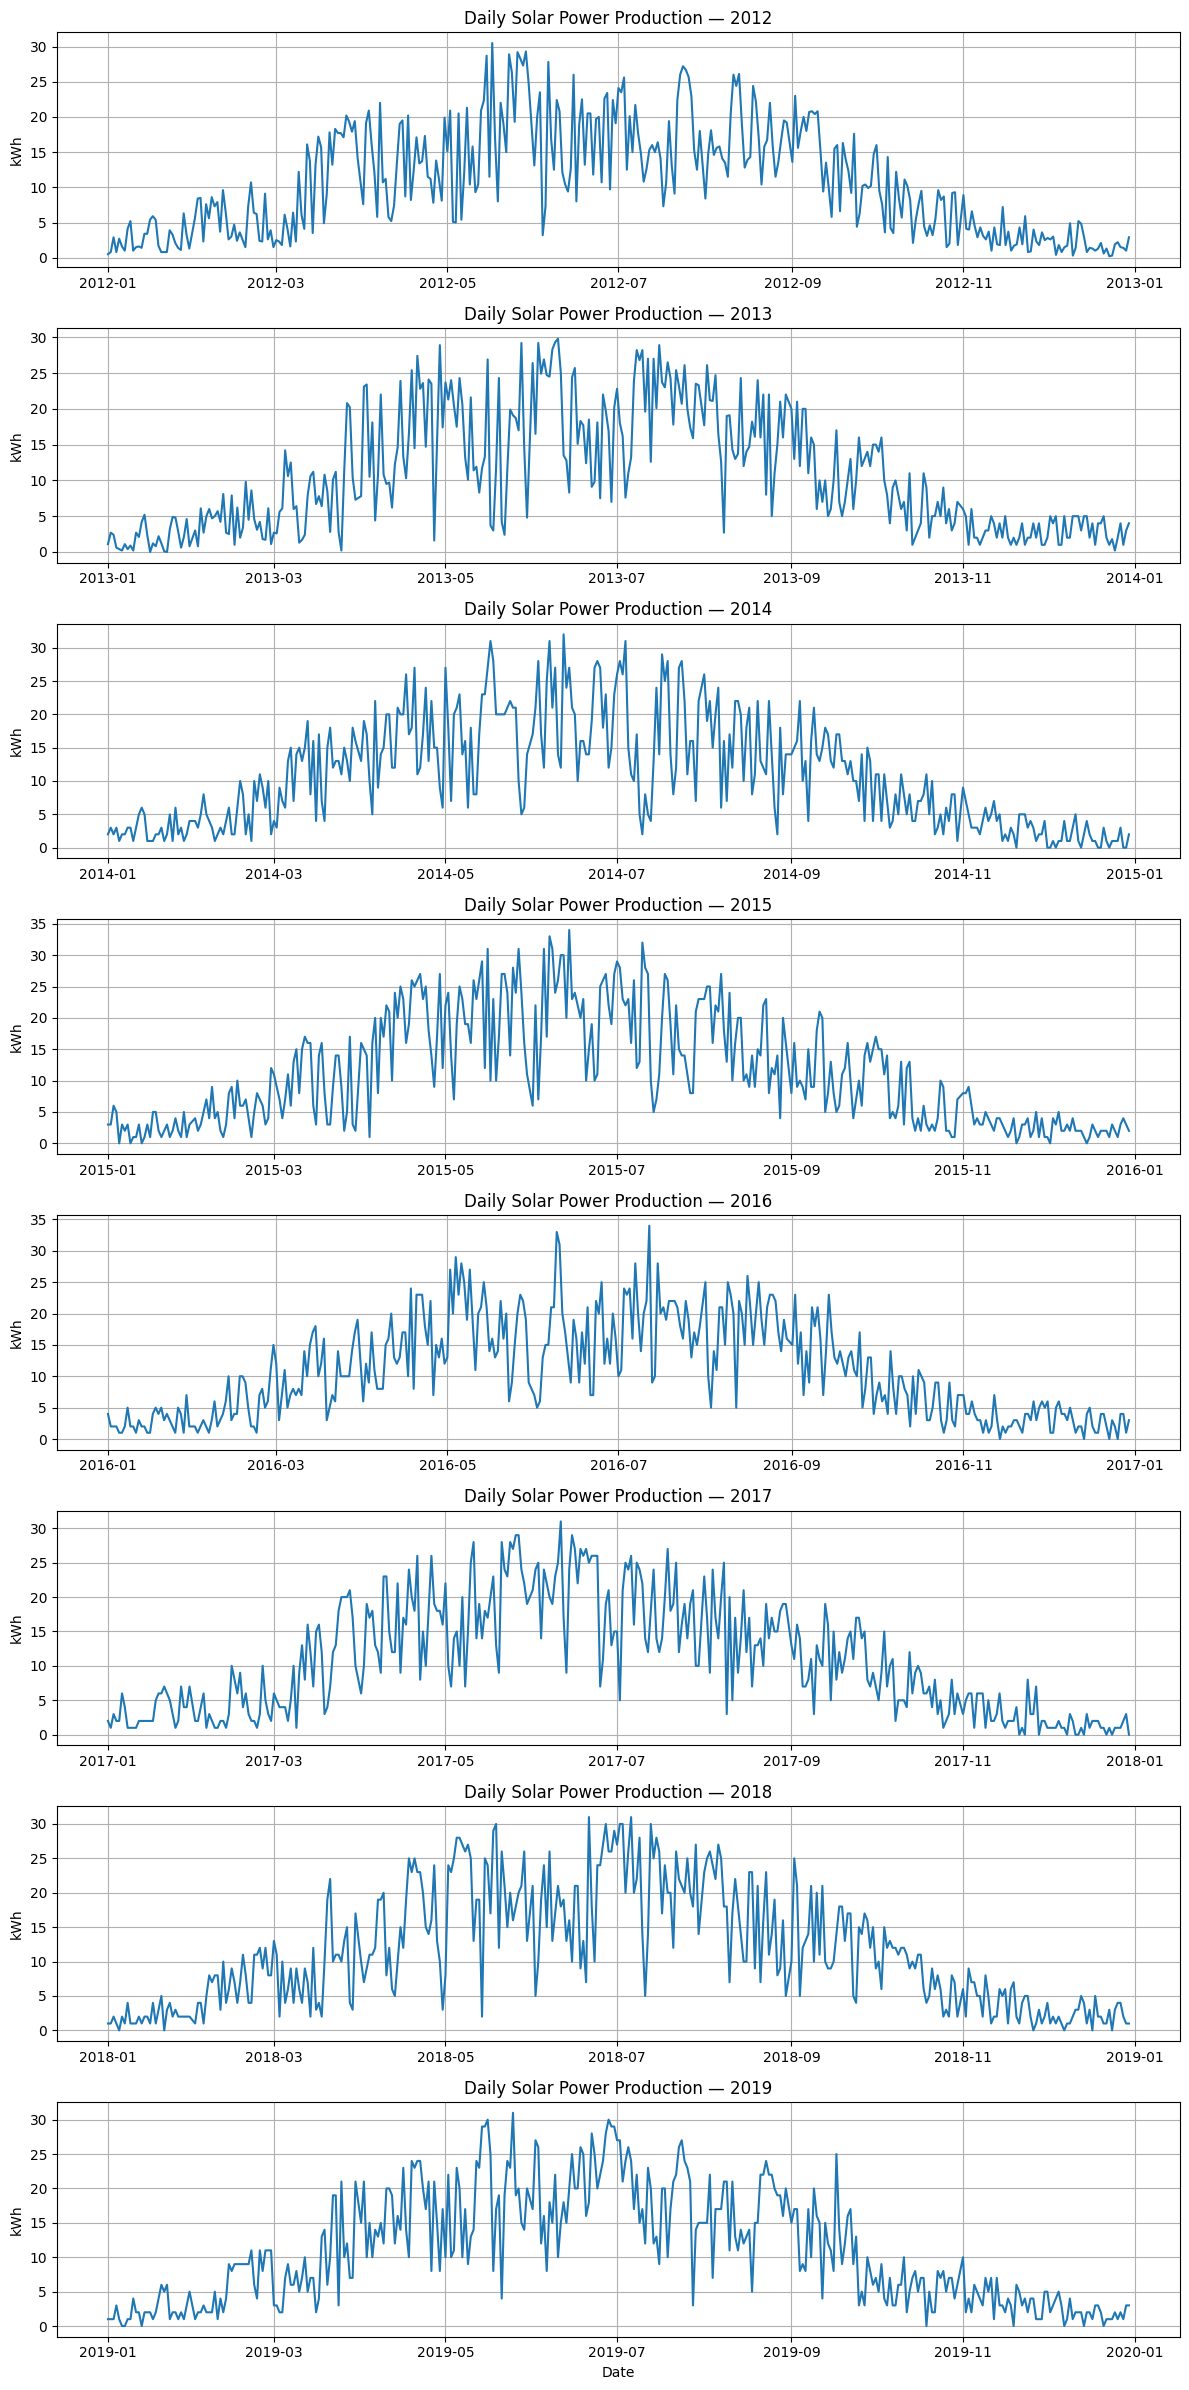

In [ ]:
# Separate yearly graphs
years = sorted(final_data['year'].unique())
fig, axes = plt.subplots(len(years), 1, figsize=(12, 3 * len(years)), sharex=False)
for ax, year in zip(axes, years):
    yearly_data = final_data[final_data['year'] == year]
    ax.plot(yearly_data['date'], yearly_data['daily_solar_power'], color='tab:blue')
    ax.set_title(f'Daily Solar Power Production — {year}')
    ax.set_ylabel('kWh')
    ax.grid(True)
axes[-1].set_xlabel('Date')
plt.tight_layout()
plt.show()


In [ ]:
# =========================================
# 7. Data Loading, Cleaning, Merge
# =========================================
import pandas as pd
import numpy as np

# Load and clean solar data
solar = pd.read_csv("panel.csv")
solar['date'] = pd.to_datetime(solar['date'], dayfirst=True, errors="coerce")
solar.rename(columns={
    "Cumulative_solar_power": "cumulative_solar_power",
    "kWh electricity/day": "kwh_electricity_day",
    "Gas/day": "gas_day"
}, inplace=True)
solar['cumulative_solar_power'] = solar['cumulative_solar_power'].ffill()
solar['kwh_electricity_day'] = solar['kwh_electricity_day'].fillna(solar['kwh_electricity_day'].median())
solar['gas_day'] = solar['gas_day'].fillna(solar['gas_day'].median())
solar['daily_solar_power'] = solar['cumulative_solar_power'].diff().fillna(0)

# Load and clean weather data
weather = pd.read_csv("weather_in_Antwerp.csv", sep=";", engine='python', on_bad_lines='skip')
weather['date'] = pd.to_datetime(weather[['year', 'month', 'day']], errors='coerce')

def clean_numeric(df, col, unit=""):
    return pd.to_numeric(
        df[col].astype(str)
        .str.replace(unit, "", regex=False)
        .str.replace(",", ".", regex=False)
        .str.strip(),
        errors="coerce"
    )

weather['temp_celsius'] = clean_numeric(weather, "temp", "°C")
weather['humidity'] = clean_numeric(weather, "humidity", "%")
weather['wind_speed_kmh'] = clean_numeric(weather, "wind", " km/h")
weather['pressure_hpa'] = clean_numeric(weather, "barometer", " mbar")
weather['temp_celsius'] = weather['temp_celsius'].fillna(weather['temp_celsius'].median())

# Daily aggregation
weather_daily = weather.groupby("date").agg({
    "temp_celsius": "mean",
    "humidity": "mean",
    "wind_speed_kmh": "mean",
    "pressure_hpa": "mean",
    "weather": lambda x: x.mode()[0] if not x.mode().empty else "unknown"
}).reset_index()

# Merge data
final_data = pd.merge(solar, weather_daily, on="date", how="inner")
final_data['date'] = pd.to_datetime(final_data['date'])
final_data['year'] = final_data['date'].dt.year

# =========================================
# Add Seasonal Features
# =========================================
final_data['day_of_year'] = final_data['date'].dt.dayofyear
final_data['month'] = final_data['date'].dt.month
final_data['week'] = final_data['date'].dt.isocalendar().week.astype(int)

final_data['dayofyear_sin'] = np.sin(2 * np.pi * final_data['day_of_year'] / 365)
final_data['dayofyear_cos'] = np.cos(2 * np.pi * final_data['day_of_year'] / 365)
final_data['month_sin'] = np.sin(2 * np.pi * final_data['month'] / 12)
final_data['month_cos'] = np.cos(2 * np.pi * final_data['month'] / 12)

final_data.head()


,date,cumulative_solar_power,kwh_electricity_day,gas_day,daily_solar_power,temp_celsius,humidity,wind_speed_kmh,pressure_hpa,weather,year,day_of_year,month,week,dayofyear_sin,dayofyear_cos,month_sin,month_cos
0,2012-01-01,226.7,16.0,13.6,0.5,12.333333,89.333333,21.333333,1007.866667,Mostly cloudy.,2012,1,1,52,0.017213,0.999852,0.5,0.866025
1,2012-01-02,227.5,18.8,10.6,0.8,7.787234,81.425532,17.212766,1009.170213,Passing clouds.,2012,2,1,1,0.034422,0.999407,0.5,0.866025
2,2012-01-03,230.4,15.5,11.7,2.9,8.208333,78.229167,32.354167,1007.916667,Clear.,2012,3,1,1,0.051620,0.998667,0.5,0.866025
3,2012-01-04,231.2,19.3,19.3,0.8,7.354167,71.041667,26.375000,1012.687500,Passing clouds.,2012,4,1,1,0.068802,0.997630,0.5,0.866025
4,2012-01-05,233.9,6.9,10.6,2.7,8.292683,77.804878,39.170732,998.219512,Partly cloudy.,2012,5,1,1,0.085965,0.996298,0.5,0.866025


In [ ]:
# ---- Lag features for RNN (past solar power) ----
final_data = final_data.sort_values("date").reset_index(drop=True)

for lag in [1, 7]:
    final_data[f"lag_{lag}"] = final_data["daily_solar_power"].shift(lag)

# Drop first rows where lags are NaN
final_data = final_data.dropna(subset=["lag_1", "lag_7"]).reset_index(drop=True)


In [ ]:
# =========================================
# 7.1. Feature Selection + Split + Random Forest
# =========================================
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

features = [
    "temp_celsius", "humidity", "wind_speed_kmh", "pressure_hpa",
    "dayofyear_sin", "dayofyear_cos", "month_sin", "month_cos"
]

X = final_data[features].fillna(final_data[features].median())
y = final_data['daily_solar_power']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scaling for ANN later
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

# =========================================
# Random Forest (baseline)
# =========================================
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("RF R²:", r2_score(y_test, y_pred_rf))

rf_mse = mean_squared_error(y_test, y_pred_rf)
rf_rmse = rf_mse ** 0.5
print("RF RMSE:", rf_rmse)


RF R²: 0.7108948900060165
RF RMSE: 4.556161643123435


In [ ]:
# =========================================
#  Grid Search - Random Forest
# =========================================
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

rf_base = RandomForestRegressor(random_state=42)

param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10]
}

grid_search = GridSearchCV(
    rf_base,
    param_grid,
    cv=3,
    scoring="r2",
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("Best RF params:", grid_search.best_params_)
print("Best CV R²:", grid_search.best_score_)

rf_gs = grid_search.best_estimator_
y_pred_rf_gs = rf_gs.predict(X_test)

rf_gs_mse = mean_squared_error(y_test, y_pred_rf_gs)
rf_gs_rmse = rf_gs_mse ** 0.5
rf_gs_r2   = r2_score(y_test, y_pred_rf_gs)

print("GridSearch RF - Test RMSE:", rf_gs_rmse)
print("GridSearch RF - Test R²:", rf_gs_r2)


Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best RF params: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 300}
Best CV R²: 0.7038409317179779
GridSearch RF - Test RMSE: 4.470800806556412
GridSearch RF - Test R²: 0.721626325501716


In [ ]:
# =========================================
# XGBoost & CatBoost (fixed RMSE)
# =========================================
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score

xgb_model = None
cat_model = None
y_pred_xgb = None
y_pred_cat = None

# ----- XGBoost -----
try:
    from xgboost import XGBRegressor

    xgb_model = XGBRegressor(
        n_estimators=500,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        random_state=42,
        n_jobs=-1
    )
    xgb_model.fit(X_train, y_train)
    y_pred_xgb = xgb_model.predict(X_test)

    # ✅ no squared=False here
    xgb_mse = mean_squared_error(y_test, y_pred_xgb)
    xgb_rmse = xgb_mse ** 0.5
    xgb_r2   = r2_score(y_test, y_pred_xgb)
    print("✅ XGBoost - RMSE:", xgb_rmse, "R²:", xgb_r2)

except ImportError as e:
    print("⚠️ XGBoost not installed. Install with: pip install xgboost")
    print(e)
except Exception as e:
    print("⚠️ XGBoost error during training/evaluation:")
    print(e)

# ----- CatBoost -----
try:
    from catboost import CatBoostRegressor

    cat_model = CatBoostRegressor(
        depth=6,
        learning_rate=0.05,
        n_estimators=600,
        loss_function='RMSE',
        random_state=42,
        verbose=False
    )
    cat_model.fit(X_train, y_train)
    y_pred_cat = cat_model.predict(X_test)

    # ✅ no squared=False here either
    cat_mse = mean_squared_error(y_test, y_pred_cat)
    cat_rmse = cat_mse ** 0.5
    cat_r2   = r2_score(y_test, y_pred_cat)
    print("✅ CatBoost - RMSE:", cat_rmse, "R²:", cat_r2)

except ImportError as e:
    print("⚠️ CatBoost not installed. Install with: pip install catboost")
    print(e)
except Exception as e:
    print("⚠️ CatBoost error during training/evaluation:")
    print(e)


✅ XGBoost - RMSE: 4.741639697215881 R²: 0.686877250912945
⚠️ CatBoost not installed. Install with: pip install catboost
No module named 'catboost'


In [ ]:
# =========================================
# 8. Evaluation Metrics (Random Forest)
# =========================================
mse = mean_squared_error(y_test, y_pred_rf)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_rf)

print("\nRandom Forest Performance:")
print(f"MSE: {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R² Score: {r2:.3f}")



Random Forest Performance:
MSE: 20.759
RMSE: 4.556
R² Score: 0.711


/tmp/ipython-input-676663767.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="importance", y="feature", data=feat_imp, palette="viridis")


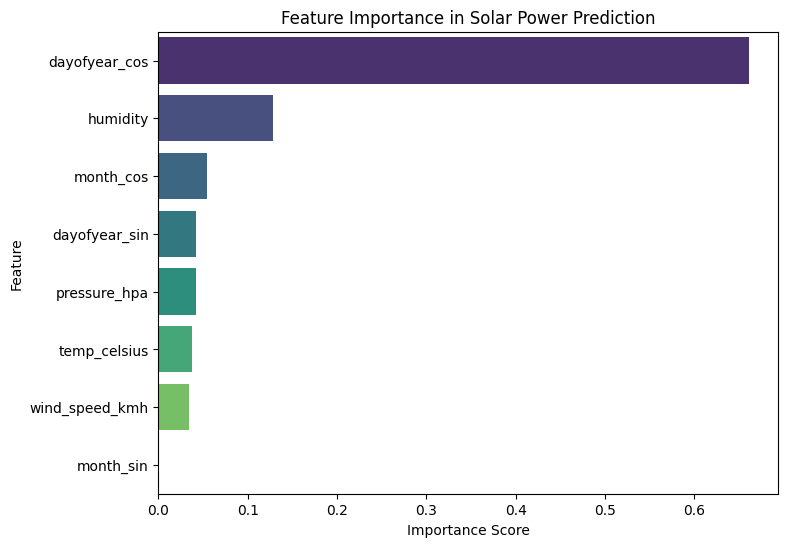

In [ ]:
# =========================================
# 9. Feature Importance (GridSearch RF)
# =========================================

# rf_gs is already the best RandomForestRegressor
best_rf = rf_gs

feat_imp = pd.DataFrame({
    "feature": X.columns,
    "importance": best_rf.feature_importances_
}).sort_values(by="importance", ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x="importance", y="feature", data=feat_imp, palette="viridis")
plt.title("Feature Importance in Solar Power Prediction")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()


In [ ]:
# =========================================
# 10. Save Model
# =========================================
import joblib

joblib.dump(rf_gs, "solar_model.pkl")   # Best model
joblib.dump(scaler, "scaler.pkl")       # Scaler used during training

print("✅ Saved best model as solar_model.pkl")
print("✅ Saved scaler as scaler.pkl")


✅ Saved best model as solar_model.pkl
✅ Saved scaler as scaler.pkl


In [ ]:

# =========================================
# 11. One-Hot Encode Weather (Optional)
# =========================================
final_data_encoded = pd.get_dummies(final_data, columns=['weather'], drop_first=True)
print("Shape after one-hot encoding:", final_data_encoded.shape)

Shape after one-hot encoding: (2858, 50)


In [ ]:
# =========================================
# 12. Check Input Data
# =========================================
print("Shape:", final_data.shape)
print("\nMissing values per column:\n", final_data.isnull().sum())
print("\nData types:\n", final_data.dtypes)
print("\nDuplicate rows:", final_data.duplicated().sum())

# Basic summary of the target
print("\nTarget (daily_solar_power) stats:\n", final_data['daily_solar_power'].describe())


Shape: (2858, 20)

Missing values per column:
 date                      0
cumulative_solar_power    0
kwh_electricity_day       0
gas_day                   0
daily_solar_power         0
temp_celsius              0
humidity                  0
wind_speed_kmh            0
pressure_hpa              0
weather                   0
year                      0
day_of_year               0
month                     0
week                      0
dayofyear_sin             0
dayofyear_cos             0
month_sin                 0
month_cos                 0
lag_1                     0
lag_7                     0
dtype: int64

Data types:
 date                      datetime64[ns]
cumulative_solar_power           float64
kwh_electricity_day              float64
gas_day                          float64
daily_solar_power                float64
temp_celsius                     float64
humidity                         float64
wind_speed_kmh                   float64
pressure_hpa                     float

In [ ]:
# =========================================
# 13. Normalization
# =========================================
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

features = ["temp_celsius", "humidity", "wind_speed_kmh", "pressure_hpa"]
target = "daily_solar_power"

X = final_data[features].fillna(final_data[features].median())
y = final_data[target].fillna(final_data[target].median())

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalization for ANN
scaler_std = StandardScaler()
X_train_std = scaler_std.fit_transform(X_train)
X_test_std = scaler_std.transform(X_test)

# Normalization for RNN
scaler_minmax = MinMaxScaler()
X_scaled = scaler_minmax.fit_transform(X)


In [ ]:
# =========================================
# 14. Artificial Neural Network (ANN)
# =========================================
import tensorflow as tf
from tensorflow.keras import layers, models

ann = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_std.shape[1],)),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

ann.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
history_ann = ann.fit(X_train_std, y_train, validation_data=(X_test_std, y_test), epochs=50, batch_size=32, verbose=0)

y_pred_ann = ann.predict(X_test_std).ravel()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [ ]:
# =========================================
# 15. Recurrent Neural Network (RNN) - IMPROVED
# =========================================
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Helper to make sequences
def make_sequences(X, y, window=30):
    Xs, ys = [], []
    for i in range(window, len(X)):
        Xs.append(X[i-window:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

# Features for the RNN (weather + seasonality + lagged power)
rnn_features = [
    "temp_celsius", "humidity", "wind_speed_kmh", "pressure_hpa",
    "dayofyear_sin", "dayofyear_cos", "month_sin", "month_cos",
    "lag_1", "lag_7"
]

# Make sure there are no missing values in these columns
final_rnn = final_data.dropna(subset=rnn_features + ["daily_solar_power"]) \
                      .sort_values("date") \
                      .reset_index(drop=True)

X_rnn = final_rnn[rnn_features].values
y_rnn = final_rnn["daily_solar_power"].values

# Scale X with MinMax for RNN
X_scaler_rnn = MinMaxScaler()
X_rnn_scaled = X_scaler_rnn.fit_transform(X_rnn)

# ✅ Scale y as well (very important!)
y_scaler = MinMaxScaler()
y_rnn_scaled = y_scaler.fit_transform(y_rnn.reshape(-1, 1)).ravel()

# Use a longer history window (e.g. 30 days)
window = 30
X_seq, y_seq = make_sequences(X_rnn_scaled, y_rnn_scaled, window=window)

# Train/test split in time order (no shuffling)
split = int(len(X_seq) * 0.8)
X_train_seq, X_test_seq = X_seq[:split], X_seq[split:]
y_train_seq, y_test_seq = y_seq[:split], y_seq[split:]

# Build a deeper LSTM with more capacity
rnn = models.Sequential([
    layers.Bidirectional(
        layers.LSTM(128, return_sequences=True),
        input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])
    ),
    layers.Dropout(0.2),

    layers.LSTM(64, return_sequences=False),
    layers.Dropout(0.2),

    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)

rnn.compile(optimizer=optimizer,
            loss='mse',
            metrics=[tf.keras.metrics.RootMeanSquaredError()])

# Early stopping to stop when val_loss stops improving
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

history_rnn = rnn.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=200,
    batch_size=32,
    callbacks=[early_stop],
    verbose=0
)

# Predict and invert scaling back to original kWh
y_pred_rnn_scaled = rnn.predict(X_test_seq).ravel()
y_pred_rnn = y_scaler.inverse_transform(y_pred_rnn_scaled.reshape(-1, 1)).ravel()
y_test_seq_orig = y_scaler.inverse_transform(y_test_seq.reshape(-1, 1)).ravel()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step


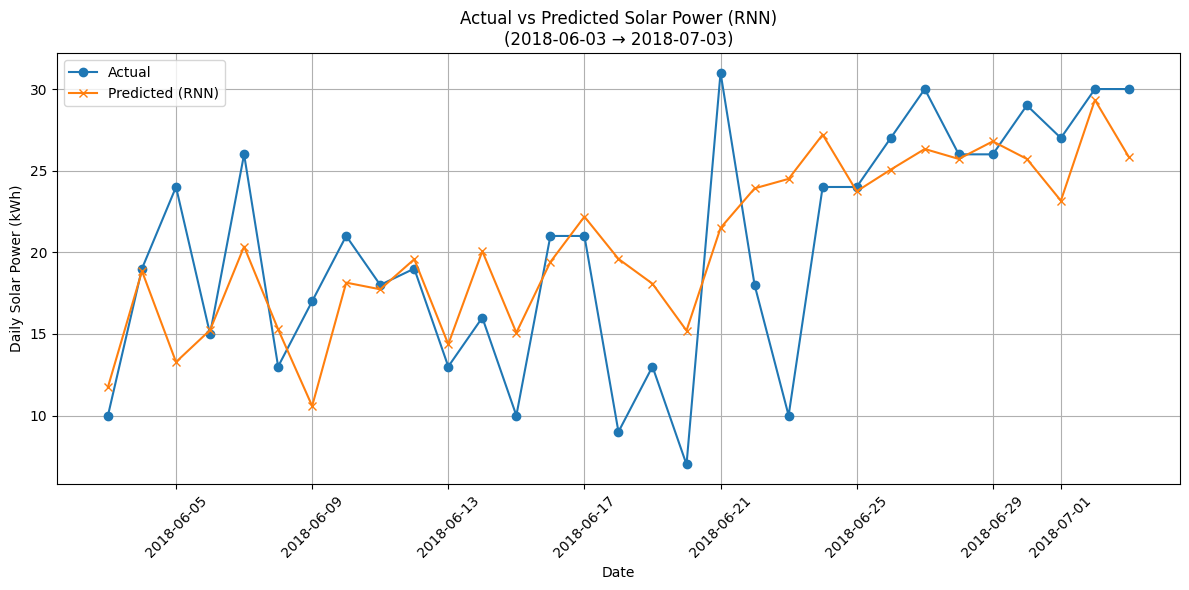

In [ ]:
# =========================================
# Actual vs Predicted (RNN - LSTM) - UPDATED
# =========================================

# dates aligned with sequence targets
dates_all = final_rnn["date"].values
n = len(dates_all)
n_seq = n - window
split = int(n_seq * 0.8)

seq_indices = np.arange(window, n)  # [window ... n-1]
test_seq_indices = seq_indices[split:]

dates_rnn = final_rnn.iloc[test_seq_indices]["date"].reset_index(drop=True)

test_results = pd.DataFrame({
    "date": dates_rnn,
    "actual_solar_power": y_test_seq_orig,
    "predicted_solar_power": y_pred_rnn
})

# choose a 1-month window
sample_start_date = test_results["date"].min()
sample_end_date = sample_start_date + pd.Timedelta(days=30)

sample_data = test_results[
    (test_results["date"] >= sample_start_date) &
    (test_results["date"] <= sample_end_date)
]

plt.figure(figsize=(12, 6))
plt.plot(sample_data["date"], sample_data["actual_solar_power"],
         label="Actual", marker="o")
plt.plot(sample_data["date"], sample_data["predicted_solar_power"],
         label="Predicted (RNN)", marker="x")
plt.xlabel("Date")
plt.ylabel("Daily Solar Power (kWh)")
plt.title(f"Actual vs Predicted Solar Power (RNN)\n({sample_start_date.date()} → {sample_end_date.date()})")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# =========================================
#  Conv1D Neural Network (Time Series)
# =========================================
import tensorflow as tf
from tensorflow.keras import layers, models

conv1d_model = models.Sequential([
    layers.Input(shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='causal'),
    layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='causal'),
    layers.GlobalAveragePooling1D(),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

conv1d_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')]
)

history_conv1d = conv1d_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=50,
    batch_size=32,
    verbose=0
)

y_pred_conv1d = conv1d_model.predict(X_test_seq).ravel()


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [ ]:
# =========================================
# TimesNet-style Neural Network (Simplified)
# =========================================
from tensorflow.keras import Input, Model

inp = Input(shape=(X_train_seq.shape[1], X_train_seq.shape[2]))

branches = []
for k in [3, 5, 7]:
    x = layers.Conv1D(64, kernel_size=k, padding='causal', activation='relu')(inp)
    x = layers.Conv1D(64, kernel_size=k, padding='causal', activation='relu')(x)
    x = layers.GlobalAveragePooling1D()(x)
    branches.append(x)

x = layers.Concatenate()(branches)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.2)(x)
out = layers.Dense(1)(x)

timesnet_model = Model(inputs=inp, outputs=out)

timesnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')]
)

history_timesnet = timesnet_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=50,
    batch_size=32,
    verbose=0
)

y_pred_timesnet = timesnet_model.predict(X_test_seq).ravel()


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


/tmp/ipython-input-1863917413.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="R² Score", data=results, palette="coolwarm")


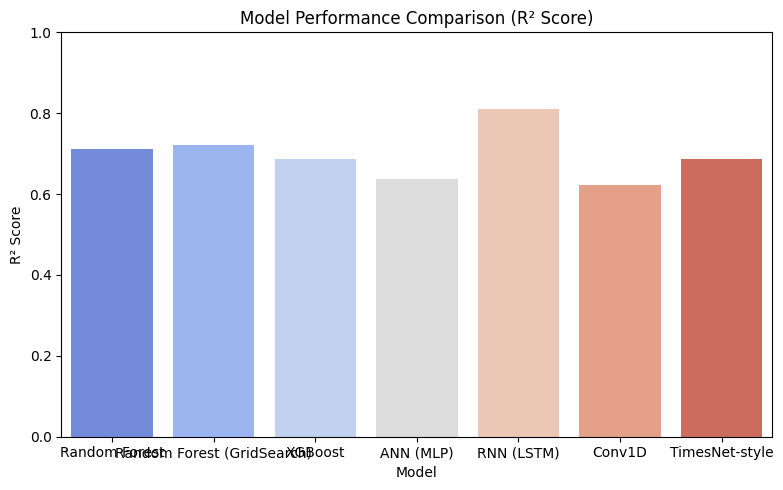

/tmp/ipython-input-1863917413.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="RMSE", data=results, palette="viridis")


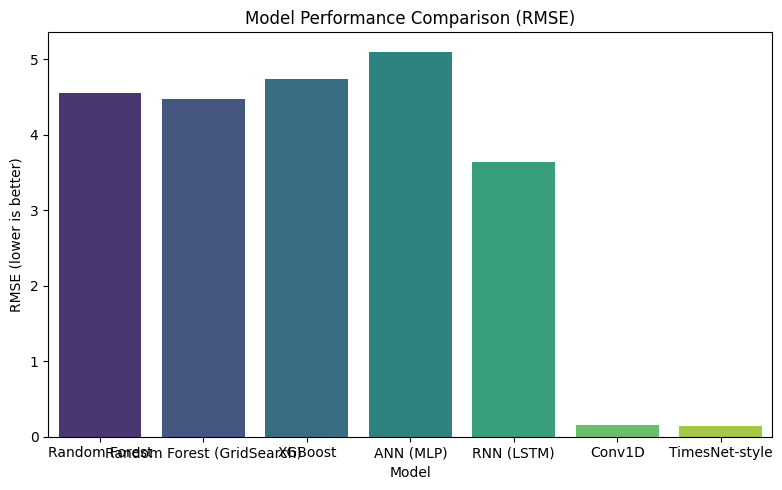

In [ ]:
# =========================================
# 17. Visual Comparison of Model Accuracy
# =========================================
import matplotlib.pyplot as plt
import seaborn as sns

# Bar chart comparing R² and RMSE
plt.figure(figsize=(8,5))
sns.barplot(x="Model", y="R² Score", data=results, palette="coolwarm")
plt.title("Model Performance Comparison (R² Score)")
plt.ylabel("R² Score")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,5))
sns.barplot(x="Model", y="RMSE", data=results, palette="viridis")
plt.title("Model Performance Comparison (RMSE)")
plt.ylabel("RMSE (lower is better)")
plt.tight_layout()
plt.show()


In [ ]:
# =========================================
# 18. Compare All Models (Final Table)
# =========================================
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

def metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = mse ** 0.5
    r2 = r2_score(y_true, y_pred)
    return rmse, r2

rows = []

# Baseline RF
rf_rmse, rf_r2 = metrics(y_test, y_pred_rf)
rows.append({"Model": "Random Forest", "RMSE": rf_rmse, "R² Score": rf_r2})

# GridSearch RF
rf_gs_rmse, rf_gs_r2 = metrics(y_test, y_pred_rf_gs)
rows.append({"Model": "Random Forest (GridSearch)", "RMSE": rf_gs_rmse, "R² Score": rf_gs_r2})

# XGBoost (if ran)
if 'y_pred_xgb' in globals() and y_pred_xgb is not None:
    xgb_rmse, xgb_r2 = metrics(y_test, y_pred_xgb)
    rows.append({"Model": "XGBoost", "RMSE": xgb_rmse, "R² Score": xgb_r2})

# CatBoost (if ran)
if 'y_pred_cat' in globals() and y_pred_cat is not None:
    cat_rmse, cat_r2 = metrics(y_test, y_pred_cat)
    rows.append({"Model": "CatBoost", "RMSE": cat_rmse, "R² Score": cat_r2})

# ANN (MLP)
ann_rmse, ann_r2 = metrics(y_test, y_pred_ann)
rows.append({"Model": "ANN (MLP)", "RMSE": ann_rmse, "R² Score": ann_r2})

# RNN (LSTM) - use unscaled y
rnn_rmse, rnn_r2 = metrics(y_test_seq_orig, y_pred_rnn)
rows.append({"Model": "RNN (LSTM)", "RMSE": rnn_rmse, "R² Score": rnn_r2})

# Conv1D
conv_rmse, conv_r2 = metrics(y_test_seq, y_pred_conv1d)
rows.append({"Model": "Conv1D", "RMSE": conv_rmse, "R² Score": conv_r2})

# TimesNet-style
times_rmse, times_r2 = metrics(y_test_seq, y_pred_timesnet)
rows.append({"Model": "TimesNet-style", "RMSE": times_rmse, "R² Score": times_r2})

results = pd.DataFrame(rows)
print(results)


                        Model      RMSE  R² Score
0               Random Forest  4.556162  0.710895
1  Random Forest (GridSearch)  4.470801  0.721626
2                     XGBoost  4.741640  0.686877
3                   ANN (MLP)  5.103436  0.637270
4                  RNN (LSTM)  3.643524  0.810930
5                      Conv1D  0.151495  0.622140
6              TimesNet-style  0.138146  0.685797
